# Predictive Maintenance for Machine

We will be working with aircraft sensor data, obtained from [Github](https://github.com/Samimust/predictive-maintenance/tree/master/data). The text files contain simulated aircraft engine run-to-failure events, operational settings, and 21 sensors measurements, which are provided by Microsoft. It is assumed that the engine progressing degradation pattern is reflected in its sensor measurements.

In [1]:
#import the modules
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn import model_selection 
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import metrics 
from sklearn.feature_selection import SelectFromModel, RFECV

In [2]:
#Import the data
df_train = pd.read_csv('Train_(Maintenance).csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


In [3]:
df_test = pd.read_csv('Test_(Maintenance).csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,0.021174,0.0,0.707107,0.0,0.0,0.124016,0.025037,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,0.011429,0.0,1.095445,0.0,0.0,0.069785,0.027820,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,0.030924,0.0,0.836660,0.0,0.0,0.143631,0.018966,69,0,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,0.021249,0.0,1.341641,0.0,0.0,0.126372,0.021106,82,0,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,0.009627,0.0,0.547723,0.0,0.0,0.091924,0.101100,91,0,0


### Summary of the Data

In [4]:
df_train.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.0,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,0.018802,0.0,0.885173,0.0,0.0,0.094636,0.056483,107.807862,0.150259,0.227813
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.007103,0.0,0.341989,0.0,0.0,0.034867,0.020669,68.880990,0.357334,0.575358
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,0.013724,0.0,0.547723,0.0,0.0,0.070071,0.041825,51.000000,0.000000,0.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,0.018365,0.0,0.836660,0.0,0.0,0.092736,0.055555,103.000000,0.000000,0.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,0.023380,0.0,1.140175,0.0,0.0,0.117132,0.069839,155.000000,0.000000,0.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,0.065761,0.0,2.828427,0.0,0.0,0.325269,0.187313,361.000000,1.000000,2.000000


In [5]:
df_test.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
count,100.000000,100.000000,100.000000,100.000000,100.0,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02,...,100.000000,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.00000,100.000000,100.000000
mean,50.500000,130.960000,-0.000073,0.000022,100.0,5.186700e+02,642.768400,1591.824700,1410.548200,1.462000e+01,...,0.019207,0.0,0.889000,0.0,0.0,0.093899,0.057975,75.52000,0.250000,0.350000
std,29.011492,53.593479,0.002353,0.000306,0.0,1.142596e-12,0.444592,6.646293,8.626344,2.856489e-14,...,0.008033,0.0,0.307613,0.0,0.0,0.035885,0.020325,41.76497,0.435194,0.657129
min,1.000000,31.000000,-0.005900,-0.000500,100.0,5.186700e+02,641.750000,1576.930000,1389.330000,1.462000e+01,...,0.004287,0.0,0.000000,0.0,0.0,0.015166,0.018966,7.00000,0.000000,0.000000
25%,25.750000,88.750000,-0.001650,-0.000300,100.0,5.186700e+02,642.490000,1587.007500,1403.912500,1.462000e+01,...,0.013697,0.0,0.707107,0.0,0.0,0.070107,0.042731,32.75000,0.000000,0.000000
50%,50.500000,133.500000,-0.000250,0.000100,100.0,5.186700e+02,642.775000,1591.365000,1410.300000,1.462000e+01,...,0.018009,0.0,0.836660,0.0,0.0,0.088544,0.055796,86.00000,0.000000,0.000000
75%,75.250000,164.250000,0.001300,0.000300,100.0,5.186700e+02,643.025000,1597.280000,1416.922500,1.462000e+01,...,0.023288,0.0,1.140175,0.0,0.0,0.114105,0.072792,112.25000,0.250000,0.250000
max,100.000000,303.000000,0.007600,0.000500,100.0,5.186700e+02,644.030000,1607.550000,1428.420000,1.462000e+01,...,0.049270,0.0,1.483240,0.0,0.0,0.187216,0.115700,145.00000,1.000000,2.000000


In [6]:
#Check the null value
df_train.isnull().sum()

id           0
cycle        0
setting1     0
setting2     0
setting3     0
            ..
sd20         0
sd21         0
ttf          0
label_bnc    0
label_mcc    0
Length: 71, dtype: int64

In [7]:
#Check the null value and the data type of each column
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 71 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         20631 non-null  int64  
 1   cycle      20631 non-null  int64  
 2   setting1   20631 non-null  float64
 3   setting2   20631 non-null  float64
 4   setting3   20631 non-null  float64
 5   s1         20631 non-null  float64
 6   s2         20631 non-null  float64
 7   s3         20631 non-null  float64
 8   s4         20631 non-null  float64
 9   s5         20631 non-null  float64
 10  s6         20631 non-null  float64
 11  s7         20631 non-null  float64
 12  s8         20631 non-null  float64
 13  s9         20631 non-null  float64
 14  s10        20631 non-null  float64
 15  s11        20631 non-null  float64
 16  s12        20631 non-null  float64
 17  s13        20631 non-null  float64
 18  s14        20631 non-null  float64
 19  s15        20631 non-null  float64
 20  s16   

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 71 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         100 non-null    int64  
 1   cycle      100 non-null    int64  
 2   setting1   100 non-null    float64
 3   setting2   100 non-null    float64
 4   setting3   100 non-null    float64
 5   s1         100 non-null    float64
 6   s2         100 non-null    float64
 7   s3         100 non-null    float64
 8   s4         100 non-null    float64
 9   s5         100 non-null    float64
 10  s6         100 non-null    float64
 11  s7         100 non-null    float64
 12  s8         100 non-null    float64
 13  s9         100 non-null    float64
 14  s10        100 non-null    float64
 15  s11        100 non-null    float64
 16  s12        100 non-null    float64
 17  s13        100 non-null    float64
 18  s14        100 non-null    float64
 19  s15        100 non-null    float64
 20  s16        

In [9]:
features = list(df_train.columns)
unwanted = ['id', 'cycle']
cleaned_features = [ele for ele in features if ele not in unwanted]

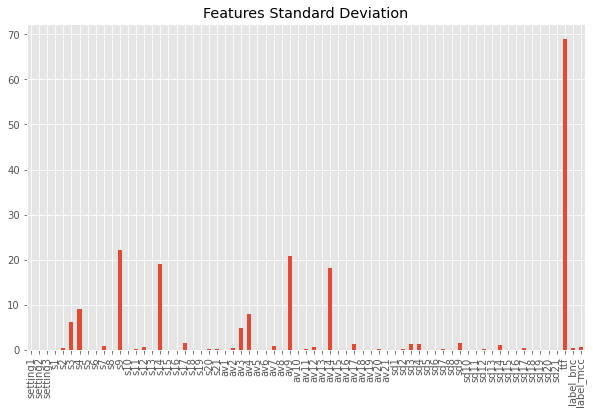

In [10]:
#plot and compare the standard deviation of input features:
df_train[cleaned_features].std().plot(kind='bar', figsize=(10,6), title="Features Standard Deviation")

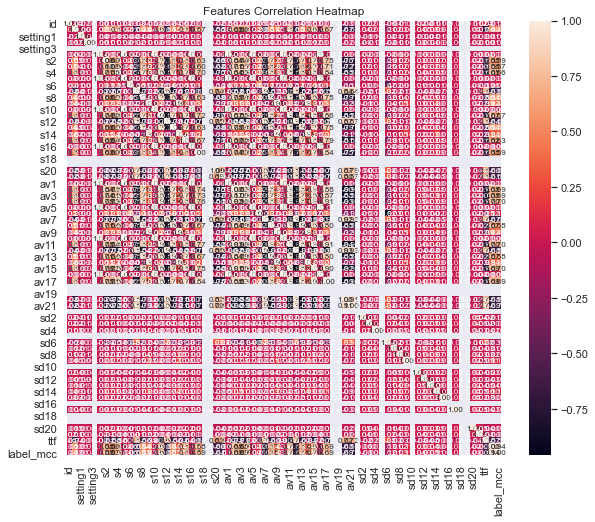

In [11]:
import seaborn as sns
sns.set(font_scale=1.0)
fig = plt.figure(figsize=(10, 8))
hm = sns.heatmap(df_train.corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8})
plt.title('Features Correlation Heatmap')
plt.show()

### ttf column

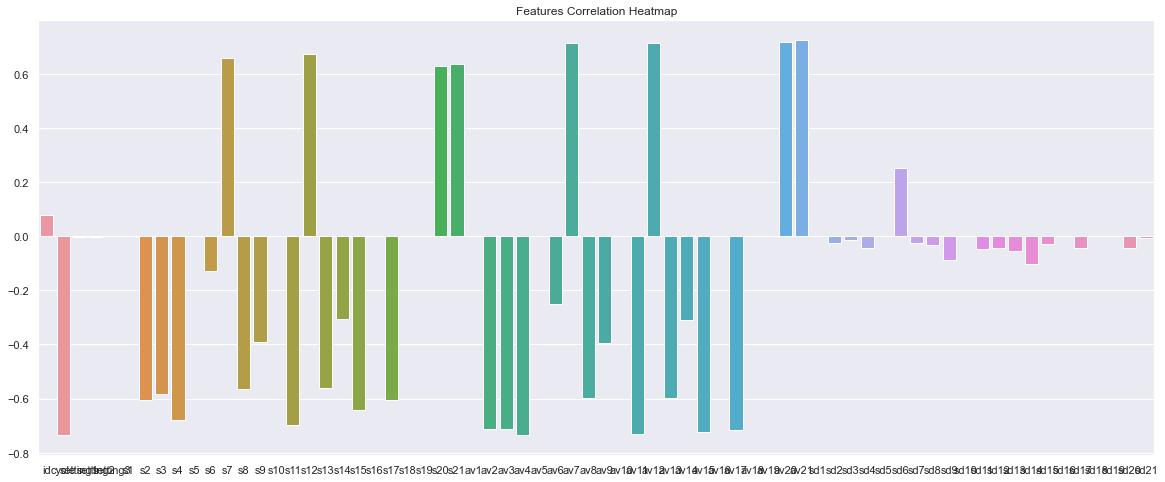

In [12]:
#ttf column
sns.set(font_scale=1.0)
fig = plt.figure(figsize=(20, 8))
hm = sns.barplot(x=df_train.corr().iloc[:-3,-3].index, y=df_train.corr().iloc[:-3,-3].values)
plt.title('Features Correlation Heatmap')
plt.show()

In [13]:
df_train.drop('id', axis=1).corr().iloc[:-3,-3].sort_values(ascending=False).head(10)

av21    7.240723e-01
av20    7.173272e-01
av12    7.132248e-01
av7     7.120920e-01
s12     6.719831e-01
s7      6.572227e-01
s21     6.356620e-01
s20     6.294285e-01
sd6     2.515574e-01
s5      1.561885e-14
Name: ttf, dtype: float64

In [14]:
df_train.drop('id', axis=1).corr().iloc[:-3,-3].sort_values(ascending=True).head(10)

cycle   -0.736241
av4     -0.732976
av11    -0.732275
av15    -0.723144
av17    -0.716599
av2     -0.711861
av3     -0.710755
s11     -0.696228
s4      -0.678948
s15     -0.642667
Name: ttf, dtype: float64

In [15]:
df_train.drop('id', axis=1).corr()['ttf'].isna()

cycle        False
setting1     False
setting2     False
setting3      True
s1           False
             ...  
sd20         False
sd21         False
ttf          False
label_bnc    False
label_mcc    False
Name: ttf, Length: 70, dtype: bool

In [16]:
ttf = df_train.drop('id', axis=1).corr()['ttf']
ttf[ttf.isna()==1]

setting3   NaN
s18        NaN
s19        NaN
av18       NaN
av19       NaN
sd1        NaN
sd5        NaN
sd10       NaN
sd16       NaN
sd18       NaN
sd19       NaN
Name: ttf, dtype: float64

In [17]:
ttf[(ttf<0.001) & (ttf>-0.001)]

s1      1.535649e-14
s5      1.561885e-14
s10     1.414118e-14
s16    -3.799205e-15
av1     1.535649e-14
av5     1.561885e-14
av10    1.414118e-14
av16   -3.799205e-15
Name: ttf, dtype: float64

In [18]:
list(ttf[ttf.isna()==1].index) + list (ttf[(ttf<0.001) & (ttf>-0.001)].index)

['setting3',
 's18',
 's19',
 'av18',
 'av19',
 'sd1',
 'sd5',
 'sd10',
 'sd16',
 'sd18',
 'sd19',
 's1',
 's5',
 's10',
 's16',
 'av1',
 'av5',
 'av10',
 'av16']

In [19]:
#These are original features
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

#These are features with low or no correlation with regression label
features_lowcr = list(ttf[ttf.isna()==1].index) + list (ttf[(ttf<0.001) & (ttf>-0.001)].index)

#These are features that have correlation with regression label
features_corrl = [i for i in features_orig if i not in features_lowcr]

#features is a variable to hold the set of features to experiment with
features = features_orig

In [20]:
features_corrl

['setting1',
 'setting2',
 's2',
 's3',
 's4',
 's6',
 's7',
 's8',
 's9',
 's11',
 's12',
 's13',
 's14',
 's15',
 's17',
 's20',
 's21']

In [21]:
X_train = df_train[features]
y_train = df_train['ttf']

X_test = df_test[features]
y_test = df_test['ttf']

In [22]:
def get_regression_metrics(model, actual, predicted):
    
    """Calculate main regression metrics.
    
    Args:
        model (str): The model name identifier
        actual (series): Contains the test label values
        predicted (series): Contains the predicted values
        
    Returns:
        dataframe: The combined metrics in single dataframe
    
    
    """
    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted)
                   }

    #return reg_metrics
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

In [23]:
def plot_features_weights(model, weights, feature_names, weights_type='c'):
    
    """Plot regression coefficients weights or feature importance.
    
    Args:
        model (str): The model name identifier
        weights (array): Contains the regression coefficients weights or feature importance
        feature_names (list): Contains the corresponding features names
        weights_type (str): 'c' for 'coefficients weights', otherwise is 'feature importance'
        
    Returns:
        plot of either regression coefficients weights or feature importance
        
    
    """
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None


In [24]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
    
    """Print the regression residuals.
    
    Args:
        model (str): The model name identifier
        y_train (series): The training labels
        y_train_pred (series): Predictions on training data
        y_test (series): The test labels
        y_test_pred (series): Predictions on test data
        
    Returns:
        Plot of regression residuals
    
    """
    
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()

In [25]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics

R^2 training: 0.580, R^2 test: 0.405


,Linear Regression
Root Mean Squared Error,32.041095
Mean Absolute Error,25.591780
R^2,0.405495
Explained Variance,0.665297


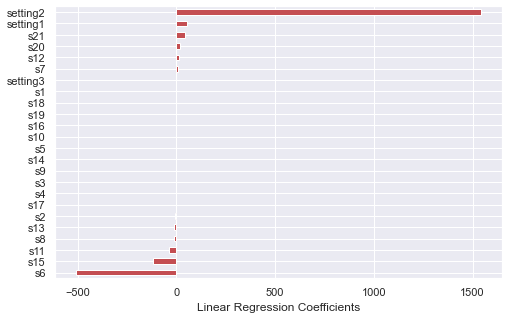

In [26]:
plot_features_weights('Linear Regression', linreg.coef_, X_train.columns, 'c')

In [27]:
rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)

y_test_predict = rfr.predict(X_test)
y_train_predict = rfr.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rfr_metrics = get_regression_metrics('Random Forest Regressor', y_test, y_test_predict)
rfr_metrics

R^2 training: 0.949, R^2 test: 0.344


,Random Forest Regressor
Root Mean Squared Error,33.658146
Mean Absolute Error,24.678000
R^2,0.343974
Explained Variance,0.581932


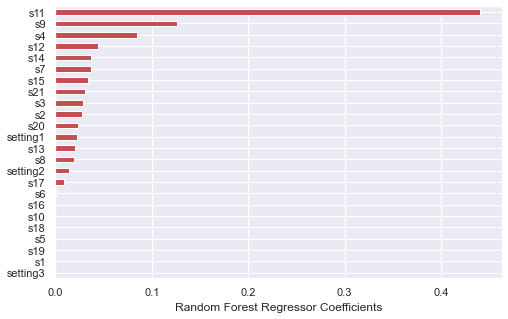

In [28]:
plot_features_weights('Random Forest Regressor', rfr.feature_importances_, X_train.columns, 'c')

In [29]:
from sklearn.svm import SVR
svr=SVR(kernel = 'linear')

svr.fit(X_train, y_train)

y_test_predict = svr.predict(X_test)
y_train_predict = svr.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rfr_metrics = get_regression_metrics('Support Vector Regression', y_test, y_test_predict)
rfr_metrics

R^2 training: 0.469, R^2 test: 0.246


,Support Vector Regression
Root Mean Squared Error,36.095126
Mean Absolute Error,29.999150
R^2,0.245538
Explained Variance,0.403296


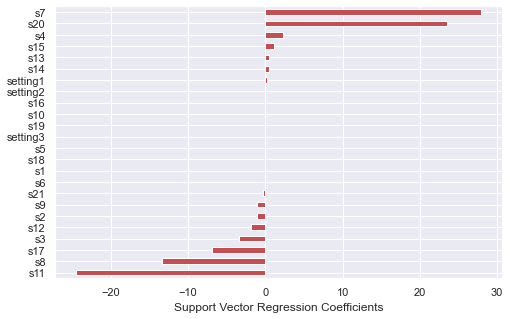

In [30]:
plot_features_weights('Support Vector Regression', svr.coef_.ravel(), X_train.columns, 'c')